In [1]:
%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import Objective, CurveFitter, PDF, Parameter, process_chain, load_chain

from FreeformVFP import FreeformVFP

In [2]:
# Version numbers allow you to repeat the analysis on your computer and obtain identical results.
import refnx, scipy
refnx.version.version, np.version.version, scipy.version.version

('0.1.42.dev0+14b2894', '1.26.2', '1.11.3')

# Load data
Three datasets are included, pNIPAM at 25 °C, 32.5 °C and 40 °C. 

pNIPAM is thermoresponsive; the 25 °C is a swollen, diffuse layer, whilst the 40 °C data is a collapsed slab.

In [3]:
data = RD("pNIPAM brush in d2o at 25C.dat")
# data = RD("pNIPAM brush in d2o at 32C.dat")
# data = RD("pNIPAM brush in d2o at 40C.dat")

# Define materials and slab components

For simplicity some parameters that may normally have been allowed to vary have been set to predetermined optimum values.

In [4]:
si = SLD(2.07, 'si')
sio2 = SLD(2.9, 'sio2')
d2o = SLD(6.23 , 'd2o')
polymer = SLD(0.81, 'polymer')

si_l = si(0, 0)
sio2_l = sio2(20, 4.8)
d2o_l = d2o(0, 0)

# Create the freeform component

In [5]:
NUM_KNOTS = 4

# Polymer layer 1
# This polymer layer is sometimes referred to as the proximal layer.
# It's a layer immediately adjacent to the Si/SiO2, just before the diffuse
# profile starts. In some brush  studies a slab-like layer is often observed in
# this location. It's hypothesised that this could be brushes that terminated
# early in the polymerisation process.
polymer_0 = polymer(2, 0.5)

# Polymer-Solvent interface (spline)
# the adsorbed amount is your prior knowledge of how much material is grafted
# It is equal to the area under the volume fraction profile of the dry brush.
# e.g. if that thickness is 150, but the estimated volume fraction for that
# dry layer is 0.8 (20 % water), then the adsorbed amount is 150 * 0.8 = 120.
# The area under the volume fraction profile for the solvated brush is equal
# to the adsorbed amount.
polymer_vfp = FreeformVFP(adsorbed_amount=120,
                          vff=[0.6] * NUM_KNOTS,
                          dzf=[1/(NUM_KNOTS + 1)] * (NUM_KNOTS + 1),
                          polymer_sld=polymer, 
                          name='freeform vfp',
                          left_slabs=[polymer_0])

# Set parameter bounds

In [6]:
sio2.real.setp(vary=True, bounds=(2.8, 3.47))

polymer_0.thick.setp(vary=True, bounds=(2, 20))
polymer_0.vfsolv.setp(vary=True, bounds=(0.1, 0.7))

# the adsorbed amount should be allowed to vary, based on what you know
# about the system. If you are very sure about the adsorbed amount then you
# can set tight bounds. If you are uncertain about the adsorbed amount then
# you should set more relaxed bounds.
polymer_vfp.adsorbed_amount.setp(vary=True, bounds=(100, 130))


# We can enforce a monotonic volume fraction profile through the bounds we
# place on the fractional volume fraction changes.
enforce_mono = True

if enforce_mono:
    bounds = (0.1, 1)
else:
    bounds = (0.1, 1.5)

# Here we set the bounds on the knot locations
for idx in range(NUM_KNOTS):
    polymer_vfp.vff[idx].setp(vary=True, bounds=bounds)
    polymer_vfp.dzf[idx].setp(vary=True, bounds=(0.05, 1))

polymer_vfp.dzf[-1].setp(vary=True, bounds=(0.05, 1))

polymer_vfp.dzf[0].setp(vary=True, bounds=(0.005, 1))

# Create the structure, model, objective

In [7]:
structure =  si_l | sio2_l | polymer_0 | polymer_vfp | d2o_l

# contracting the slab representation reduces computation time.
structure.contract = 1.5

model = ReflectModel(structure)
model.bkg.setp(vary=True, bounds=(1e-6, 1e-5))
objective = Objective(model, data)

In [8]:
# perform a fit. You may have to run this a few times to find a good solution.
# (alternatively you might need to improve your model).
# In this example notebook we set a seed to get reproducible minimisation for
# demonstration purposes. You will want to remove that if you want to run
# the minimiser repeatedly.

rng = np.random.default_rng(1)

fitter= CurveFitter(objective)
fitter.fit('differential_evolution', seed=rng);

-455.8424206734785: : 11it [00:01,  5.81it/s]/Users/andrew/Documents/Andy/programming/refnx-models/polymer_brushes/FreeformVFP.py:286: RuntimeWarning: extent > 10000, perfoming refl. calc on first 10000A.
  warnings.warn('extent > %d, perfoming refl. calc on first %dA.' %
-1086.8332358519335: : 151it [00:25,  5.84it/s]


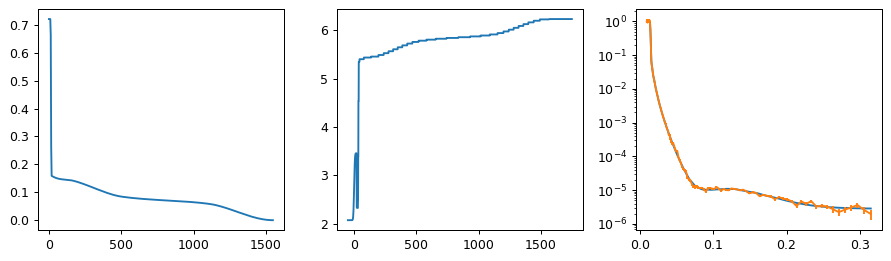

In [9]:
fig, [ax_vfp, ax_sld, ax_refl] = plt.subplots(1, 3, figsize=(10,3), dpi=90)
z = np.linspace(-50, 1750, 2000)

ax_vfp.plot(*polymer_vfp.profile())
ax_sld.plot(*structure.sld_profile(z))
ax_refl.plot(data.x, objective.generative())
ax_refl.errorbar(data.x, data.y, yerr=data.y_err)

ax_refl.set_yscale('log')

fig.tight_layout()

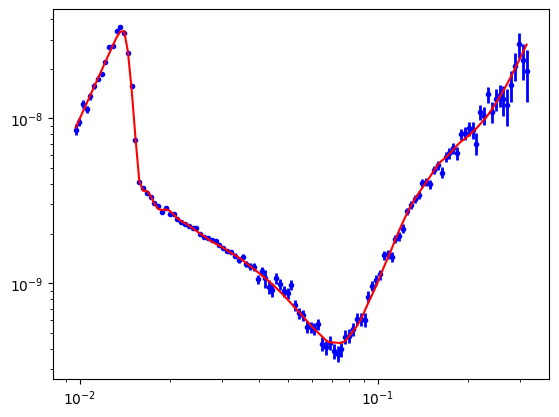

In [10]:
from refnx.analysis import Transform
t = Transform('YX4')
objective.transform = t
objective.plot()
plt.xscale('log')
plt.yscale('log')